# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

### My notes while reading the [paper](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf):
- use greyscale to preprocess
- Each stage is composed of a (convolutional) filter bank layer, a non-linear transform layer, and a spatial feature pooling layer
- In the present work the outputs of all the stages are fed to the classifier
- The motivation for combining representation from multiple stages in the classifier is to provide different scales of receptive fields to the classifier
- Mixing all images at random and subsequently separating into training and validation will result in very similar sets, and will not accurately predict performance on the unseen test set. We extract 1 track at random per class for validation, yielding 1,290 samples for validation and 25,350 for training
- YUV space. The Y channel is then preprocessed with global and local contrast normalization while U and V channels are left unchanged. Global normalization first centers each image around its mean value, whereas local normalization (see II-B) emphasizes edges.
    -  In YUV, Y is the luminance (brightness) component while U and V are the chrominance (color) components.
- we build a jittered dataset by adding 5 transformed versions of the original training set, yielding 126,750 samples in total. Samples are randomly perturbed in position ([-2,2] pixels), in scale ([.9,1.1] ratio) and rotation ([-15,+15] degrees).
- Using this idea, we can empirically search for an optimal architecture very quickly
- It uses the 108-200 feature sizes and the 2-layer classifier with 100 hidden units
- 2-layer ConvNet ms 108 feats (98.97%): This network uses 108 features at the first stage (100 connected to grayscale Y input channel and 8 to U and V color channels) and 108 features at the second stage.

### Notes from [this confluence question](https://carnd-udacity.atlassian.net/wiki/questions/19989175/traffic-signs-recognition---feels-like-im-shooting-in-the-dark)
- cv2.normalize
- [tensorflow youtube videos](https://www.youtube.com/playlist?list=PL9Hr9sNUjfsmEu1ZniY0XpHSzl5uihcXZ)
- [tensorflow CNN tutorial ipynb](https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/02_Convolutional_Neural_Network.ipynb)
- dropout
- Shuffling data is used to `refresh` your model during training


### Takeaways:
- preprocessing:
    - grey scale
    - YUV channel
- architecture:
    - 2 layer?
- generate additional data: 
    - jiggling approach in paper
    
### Attack plan
1. implement the LaCun model, I should observer loss decay
2. separate training data into 5 folds and obtain min cross validation error
3. addons:
    - try pre-processing tricks: grey scale, YUV channel
    - try generate additional data (jiggling approach)
    - hyper parameter tuning
    - activation function in paper
    - try advanced architecture in paper (skip layers, new activation function)

---
## Step 0: Load The Data

In [3]:
# Load pickled data
import pickle
import numpy as np

# TODO: Fill this in based on where you saved the training and testing data

training_file = "C:\\Users\\AW51R2\\code\\carnd\\traffic-signs-data\\train.p"
testing_file = "C:\\Users\\AW51R2\\code\\carnd\\traffic-signs-data\\test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

In [33]:
# Load sign names into dic
sign_file = "C:\\Users\\AW51R2\\code\\carnd\\traffic-signs\\signnames.csv"

signnames = {}

with open(sign_file, mode='r') as f:
    lines = f.readlines()
    for line in lines[1:]:
        t = line.split(',')
        signnames[t[0]] = t[1]


---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [4]:
### Replace each question mark with the appropriate value.

# TODO: Number of training examples
n_train = train['labels'].size

# TODO: Number of testing examples.
n_test = test['labels'].size

# TODO: What's the shape of an traffic sign image?
image_shape = train['features'][0].shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = np.unique(np.concatenate([train['labels'], test['labels']])).size

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

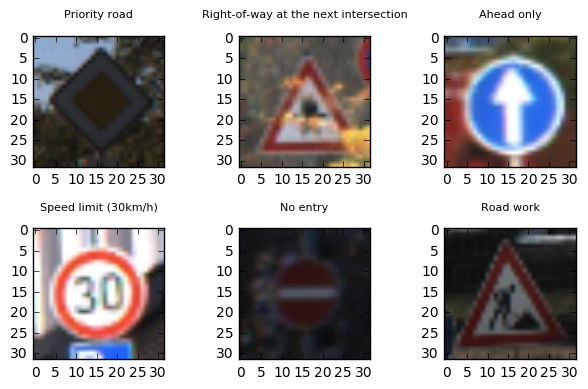

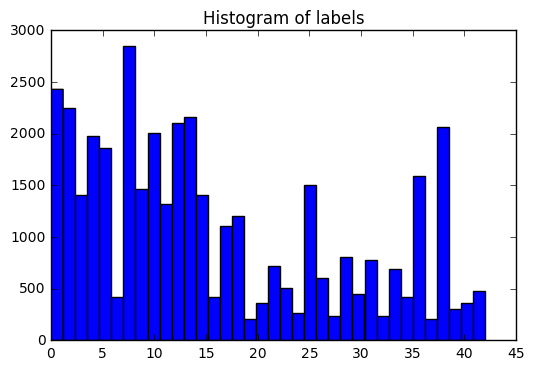

In [55]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

import random

# plot some images
fig = plt.figure()
for i in range(6):
    e = random.randint(0, n_train)
    label = y_train[e]
    sign = signnames[str(label)]
    p = fig.add_subplot(2,3,i+1)
    p.set_title(sign, fontsize = 8)
    plt.imshow(X_train[e])

plt.tight_layout()
plt.show()


# histogram of labels
plt.hist(train['labels'], bins = 'auto')
plt.title('Histogram of labels')
plt.show()




----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [56]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.

def one_hot(a):
    b = np.zeros((a.size, n_classes))
    b[np.arange(a.size),a] = 1
    return b

train_features = train['features'].astype(float)
train_features = train_features / 255. - 0.5
train_labels = one_hot(train['labels'])

test_features = test['features'].astype(float)
test_features = test_features / 255. - 0.5
test_labels = one_hot(test['labels'])


### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**
- convert all data to float type
- normalized RGB color
- apply one hot encoding to labels

In [62]:
### Generate data additional data (OPTIONAL!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.
import cv2
from sklearn.model_selection import train_test_split

TRANSLATE_DELTA = 4
JIGGLE_COPY = 1 # TODO: change for full train later

train_and_jiggle = [train_features]
train_and_jiggle_labels = [train_labels]

for i in range(JIGGLE_COPY):
    train_and_jiggle.append(np.copy(train_features))
    train_and_jiggle_labels.append(np.copy(train_labels))

for i in range(n_train):
    for j in range(JIGGLE_COPY):
        m = np.float32([[1,0,random.uniform(0.9,1.1)*TRANSLATE_DELTA], [0,1,random.uniform(0.9,1.1)*TRANSLATE_DELTA]])
        train_and_jiggle[j+1][i] = cv2.warpAffine(train_features[i], m, (32,32))


train_data_all = np.concatenate(train_and_jiggle)

train_label_all = np.concatenate(train_and_jiggle_labels)

print("fake data generated", train_data_all.shape)

def shuffle():
    x_train, x_validate, y_train, y_validate = train_test_split(
        train_data_all,
        train_label_all,
        test_size=0.2, random_state=42, stratify=train_label_all
    )

    return x_train, x_validate, y_train, y_validate


fake data generated (78418, 32, 32, 3)


### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**
- use scikit-learn's train_test_split to split training data into training and validation set
- for each image, generate `JIGGLE_COPY` copies of fake data by randomly translating on X and Y axis by [4*0.9, 4*1.1] pixels.

In [60]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

import tensorflow as tf

p_stdev = 0.1

layer_width = {
    'layer_1': 6,
    'layer_2': 16,
    'fully_connected': 120
}

weights = {
    'layer_1': tf.Variable(tf.truncated_normal(
        [5, 5, 3, layer_width['layer_1']], stddev=p_stdev)),
    'layer_2': tf.Variable(tf.truncated_normal(
        [5, 5, layer_width['layer_1'], layer_width['layer_2']], stddev=p_stdev)),
    'fully_connected': tf.Variable(tf.truncated_normal(
        [5*5*16, layer_width['fully_connected']], stddev=p_stdev)),
    'out': tf.Variable(tf.truncated_normal(
        [layer_width['fully_connected'], n_classes], stddev=p_stdev))
}

biases = {
    'layer_1': tf.Variable(tf.zeros(layer_width['layer_1'])),
    'layer_2': tf.Variable(tf.zeros(layer_width['layer_2'])),
    'fully_connected': tf.Variable(tf.zeros(layer_width['fully_connected'])),
    'out': tf.Variable(tf.zeros(n_classes))
}

def conv2d(x, W, b, strides=1):
    # Conv2D wrapper, with bias and relu activation
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='VALID')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)

def maxpool2d(x, k=2):
    return tf.nn.max_pool(
        x,
        ksize=[1, k, k, 1],
        strides=[1, k, k, 1],
        padding='VALID')


def LeNet(x):
    #reshape from 2D to 4D
    x = tf.reshape(x, (-1,32,32,3))

    #define architecture
    conv1 = conv2d(x, weights['layer_1'], biases['layer_1'], strides=1) #28x28x6
    conv1 = maxpool2d(conv1, k=2) #14x14x6

    conv2 = conv2d(conv1, weights['layer_2'], biases['layer_2'], strides=1) #10x10x16
    conv2 = maxpool2d(conv2, k=2) #5x5x16

    # todo: connect conv1 to fc1

    fc1 = tf.reshape(
        conv2,
        [-1, weights['fully_connected'].get_shape().as_list()[0]])
    fc1 = tf.add(tf.matmul(fc1, weights['fully_connected']), biases['fully_connected'])
    fc1 = tf.nn.relu(fc1)

    fc1 = tf.nn.dropout(fc1, 0.5)

    out = tf.add(tf.matmul(fc1, weights['out']), biases['out'])

    return out




### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**
- Based on the LaNet structure in TensorFlow lab with dropout
    - 2 convolutional network with one fully connected layer
    - dimentions:
        - ConvNet1: 14x14x6
        - ConvNet2: 5x5x16
        - Fully connected: 120

In [63]:
### Train your model here.
### Feel free to use as many code cells as needed.

# hyper parameters
EPOCHS = 5 # TODO: change later for fully train
BATCH_SIZE = 50

# setup training
# image is 32x32x3
x = tf.placeholder(tf.float32, [None, 32,32,3])
# unique labels: 43
y = tf.placeholder(tf.float32, (None, n_classes))

fc2 = LeNet(x)
# loss function
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(fc2, y))
# optimizer
opt = tf.train.AdamOptimizer(learning_rate=0.001)
train_op = opt.minimize(loss_op)
# accuracy
correct_prediction = tf.equal(tf.argmax(fc2, 1), tf.argmax(y,1))
accuracy_op = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


def eval_data(x_data,y_data):
    steps_per_epoch = x_data.shape[0] // BATCH_SIZE
    num_examples = steps_per_epoch * BATCH_SIZE
    total_acc, total_loss = 0, 0
    for step in range(steps_per_epoch):
        start = step * BATCH_SIZE
        end = min(start + BATCH_SIZE, x_data.shape[0])
        batch_x = x_data[start:end]
        batch_y = y_data[start:end]
        loss, acc = sess.run([loss_op, accuracy_op], feed_dict={x: batch_x, y: batch_y})
        total_acc += (acc * batch_x.shape[0])
        total_loss += (loss * batch_x.shape[0])

    return total_loss / num_examples, total_acc / num_examples


with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    # shuffle data:
    x_train, x_validate, y_train, y_validate = shuffle()
    steps_per_epoch = x_train.shape[0] // BATCH_SIZE

    for i in range(EPOCHS):
        for step in range(steps_per_epoch):
            start = step * BATCH_SIZE
            end = min(start + BATCH_SIZE, x_train.shape[0])
            batch_x = x_train[start:end]
            batch_y = y_train[start:end]
            loss = sess.run(train_op, feed_dict={x:batch_x, y:batch_y})

        val_loss, val_acc = eval_data(x_validate, y_validate)
        print("EPOCH {}...".format(i+1))
        print("Validation loss = {:.3f}".format(val_loss))
        print("Validation accuracy = {:.8f}".format(val_acc))
        print()

        # shuffle data:
        x_train, x_validate, y_train, y_validate = shuffle()

    print("running on test")
    test_loss, test_acc = eval_data(test_features, test_labels)
    print("test loss", test_loss, "test accuracy", test_acc)

EPOCH 1...
Validation loss = 0.838
Validation accuracy = 0.73354631

EPOCH 2...
Validation loss = 0.530
Validation accuracy = 0.83437699

EPOCH 3...
Validation loss = 0.385
Validation accuracy = 0.88319488

EPOCH 4...
Validation loss = 0.305
Validation accuracy = 0.90792332

EPOCH 5...
Validation loss = 0.273
Validation accuracy = 0.91968051

running on test
test loss 0.628029401725 test accuracy 0.854444438503


### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**
- Adam optimizer with 0.001 learning rate
- 20 epochs, batch size 50

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**
- I first tried to plugin the LaNet architecture, without doing any data preprocessing or generating additional data. 
- The first implementation demonstrated decreasing loss at each epoch, but the accuracy is very low at almost 0%
- After debugging (print out lots of values), I found out the training data is ordered (eg. first 100 images are all of same label), and the model could not learn enough in one epoch. So I shuffled training data and accuracy jumped to >80% instantly.
- Then I tried some pre-processing tricks, among all the trials 2 things gave the best boost: 
    1. normalize RGB color 
    2. generating additional data by translating the image a bit
- I also played a bit with hyperparameters, eg tuning the standard deviation of weight initialization, learning rate. But I didn't spend too much time on these as they didn't get as significant improvement as data pre-processing

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

In [ ]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**

In [ ]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.